# Informed Analysis

We'll be experimenting with the so-called improved architecture:

* numpy improved
* numcython improved

We'll be
* optimizing interfaces for each implementation
* experimenting with more cython

## Tests

In [1]:
def test_add(klass, num):
    for unk in [False, "UNK"]:
        for numericalize in [True, False]:
            voc = klass(unk=unk)
            voc.add("hello")
            if numericalize:
                voc = num(voc)
            assert "hello" in voc.string
            if unk is not False:
                assert unk in voc.string

In [2]:
def test_specials_init(klass, num):
    for unk in [False, "UNK"]:
        for numericalize in [True, False]:
            specs = {"<pad>", "<bos>", "<eos>"}
            voc = klass(specials=specs, unk=unk)
            if numericalize:
                voc = num(voc)
            for spec in specs:
                assert spec in voc.string
            if unk is not False:
                assert unk in voc.string

In [3]:
def test_strip_min_freq(klass, num):
    for numericalize in [True, False]:
        for unk in ["UNK", False]:
            all_words = {"one", "two", "three", "three_again", "four"}
            for freq, *words in [
                    (0, "one", "two", "three", "three_again", "four"),
                    (1, "one", "two", "three", "three_again", "four"),
                    (2, "two", "three", "three_again", "four"),
                    (3, "three", "three_again", "four"),
                    (4, "four")]:
                voc = klass(unk=unk)
                for _ in range(3):
                    voc.add("three")
                for _ in range(2):
                    voc.add("two")
                for _ in range(1):
                    voc.add("one")
                for _ in range(3):
                    voc.add("three_again")
                for _ in range(4):
                    voc.add("four")
                
                if numericalize:
                    voc = num(voc)

                voc.strip(min_freq=freq)
                if unk:
                    assert unk in voc.string
                for word in words:
                    assert word in voc.string
                for word in all_words:
                    if word not in words:
                        try:
                            assert word not in voc.string
                        except:
                            print(f"case numericalize={numericalize} "
                                  f"unk={unk} freq={freq} word={word} failed")

In [4]:
def test_strip_by_n(klass, num):
    for numericalize in [True, False]:
        for unk in ["UNK", False]:
            all_words = {"one", "two", "three", "three_again", "four"}
            for n_words, *words in [
                    (5, "one", "two", "three", "three_again", "four"),
                    (4, "four", "three", "three_again", "two"),
                    (3, "four", "three", "three_again"),
                    (1, "four")]:
                voc = klass(unk=unk)
                for _ in range(3):
                    voc.add("three")
                for _ in range(2):
                    voc.add("two")
                for _ in range(1):
                    voc.add("one")
                for _ in range(3):
                    voc.add("three_again")
                for _ in range(4):
                    voc.add("four")

                if numericalize:
                    voc = num(voc)

                voc.strip(n_to_keep=n_words)
                for word in words:
                    try:
                        assert word in voc.string
                    except:
                        print(f"case IN numericalize={numericalize} "
                              f"unk={unk} n_words={n_words} word={word} failed")
                for word in all_words:
                    if word not in words:
                        try:
                            assert word not in voc.string
                        except:
                            print(
                                f"case NOT_IN numericalize={numericalize} "
                                f"unk={unk} n_words={n_words} word={word} failed")

In [5]:
def test_num_identity(klass, num):
    for unk in [False, "UNK"]:
        voc = klass(unk=unk)
        voc.add("hello")
        voc = num(voc)
        assert "hello" == voc.string[voc.integer["hello"]]

In [6]:
def test_num_identity_unk(klass, num):
    voc = klass(unk="UNK")
    voc = num(voc)
    assert "UNK" == voc.string[voc.integer["jambalaya"]]

In [7]:
def test_out_of_vocab_no_unk(klass, num):
    voc = klass(unk=False)
    voc = num(voc)
    try:
        voc.string[voc.integer["jambalaya"]]
    except:
        pass  # lol, PASS!
    else:
        assert False

In [8]:
def test_sentence_1d(klass, num):
    fake_data = np.asarray(
        [2, 3, 4, 1, 2]
    )
    expected = np.asarray([
        "two three four"
    ])
    voc = klass(specials={"one"}, unk="UNK")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    s = voc.sentence(fake_data)
    assert (expected == s).all()

In [9]:
def test_sentence_1d_unk(klass, num):
    fake_data = np.asarray(
        [2, 3, 4, 0, 0]
    )
    expected = np.asarray([
        "two three four UNK UNK"
    ])
    voc = klass(unk="UNK")
    for _ in range(6):
        voc.add("one")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    voc.permit_unk(True)
    s = voc.sentence(fake_data)
    assert (expected == s).all()

In [10]:
def test_sentence_2d_axis_0(klass, num):
    fake_data = np.asarray(
        [[2, 3, 4, 1, 2],
         [3, 2, 4, 2, 1],
         [2, 3, 0, 0, 0]]
    )
    expected = np.asarray([
        "two three two", "three two three", "four four", "", "two"
    ])
    voc = klass(specials={"one"}, unk="UNK")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    s = voc.sentence(fake_data, axis=0)
    assert (expected == s).all()

In [11]:
def test_sentence_2d_axis_1(klass, num):
    fake_data = np.asarray(
        [[2, 3, 4, 1, 2],
         [3, 2, 4, 2, 1],
         [2, 3, 0, 0, 0]]
    )
    expected = np.asarray([
        "two three four", "three two four two", "two three"
    ])
    voc = klass(specials={"one"}, unk="UNK")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    s = voc.sentence(fake_data, axis=1)
    assert (expected == s).all()

In [12]:
def test_sentence_3d_axis_2(klass, num):
    fake_data = np.asarray(
        [[[2, 3, 4, 1, 2],
          [3, 2, 4, 2, 1],
          [2, 3, 0, 0, 0]],
         [[1, 0, 0, 0, 0],
          [3, 4, 2, 3, 4],
          [4, 4, 3, 3, 0]]]
    )
    expected = np.asarray([
        ["two three four", "three two four two", "two three"],
        ["", "three four two three four", "four four three three"]
    ])
    voc = klass(specials={"one"}, unk="UNK")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    s = voc.sentence(fake_data, axis=2)
    assert (expected == s).all()

In [13]:
def test_uncount_and_strip(klass, num):
    for unk in [False, "UNK"]:
        voc = klass(unk=unk)
        for _ in range(3):
            voc.add("one")
        for _ in range(5):
            voc.add("two")
        for _ in range(3):
            voc.uncount("two")
        voc.strip(min_freq=3)
        assert "one" in voc.string
        assert "two" not in voc.string

In [14]:
def test_uncount_to_death(klass, num):
    for unk in [False, "UNK"]:
        voc = klass(unk=unk)
        for _ in range(3):
            voc.add("one")
        for _ in range(5):
            voc.add("two")
        for _ in range(5):
            voc.uncount("two")
        assert "one" in voc.string
        assert "two" not in voc.string

In [15]:
def test_all(klass, num):
    tests = [test_add,
             test_specials_init,
             test_strip_min_freq,
             test_strip_by_n,
             test_num_identity,
             test_num_identity_unk,
             test_out_of_vocab_no_unk,
             test_sentence_1d,
             test_sentence_1d_unk,
             test_sentence_2d_axis_0,
             test_sentence_2d_axis_1,
             test_sentence_3d_axis_2,
             test_uncount_and_strip,
             test_uncount_to_death]
    for test in tests:
        print(f"Running {test.__name__}")
        test(klass, num)

## Benchmarks

In [16]:
import random

In [17]:
def fake_data(file="rando.txt"):
    # note: inefficient, but who cares?
    with open(file, "r") as f:
        newtxt = []
        txt = f.read()
        for c in txt:
            if c == ".":
                c = " ."
            newtxt.append(c)
    txt = "".join(newtxt).lower()
    txt = txt.replace("\n", "").split(" ")
    return txt

In [18]:
import time

In [19]:
def benchmark_adding_iterable(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        start = time.time()
        voc.add_iterable(txt)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_adding_iterable.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_adding_iterable.__name__, avg)

In [20]:
def benchmark_numericalizing(voc, num, n_trials=1000):
    queries = list(range(1000))
    start = time.time()
    # TODO: Numericalization is allowed to be destructive. This isn't necessarily right
    for _ in queries:
        _ = num(voc)
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_numericalizing.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_numericalizing.__name__, avg)

In [21]:
def benchmark_single_word_random_access(voc, n_trials=1000):
    queries = [random.randint(0, len(voc)-1) for _ in range(n_trials)]
    start = time.time()
    for query in queries:
        _ = voc.string[query]
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_single_word_random_access.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_single_word_random_access.__name__, avg)

In [22]:
def benchmark_1d_word_array_random_access(voc, n_trials=1000):
    lens = [random.randint(3, 12) for _ in range(n_trials)]
    queries = [[random.randint(0, len(voc)-1) for _ in range(len_)] for len_ in lens]
    start = time.time()
    for query in queries:
        _ = voc.string[query]
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_1d_word_array_random_access.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_1d_word_array_random_access.__name__, avg)

In [23]:
def benchmark_1d_word_array_structured_random_access(voc, n_trials=1000):
    seq_len = 20
    queries = [np.random.randint(0, len(voc)-1, (seq_len)) for _ in range(n_trials)]
    start = time.time()
    for query in queries:
        _ = voc.sentence(query, axis=0)
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_1d_word_array_structured_random_access.__name__}"
          f" ({n_trials}): {avg} s, avg")
    return (benchmark_1d_word_array_structured_random_access.__name__, avg)

In [24]:
def benchmark_2d_word_array_random_access(voc, n_trials=1000):
    batch = 64
    all_lens = [[random.randint(3, 12) for _ in range(batch)] for _ in range(n_trials)]
    queries = [
        [[random.randint(0, len(voc)-1) for _ in range(l)] for l in lens]
        for lens in all_lens]
    start = time.time()
    for query in queries:
        _ = voc.string[query]
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_2d_word_array_random_access.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_2d_word_array_random_access.__name__, avg)

In [25]:
def benchmark_2d_word_array_structured_random_access(voc, n_trials=1000):
    seq_len = 20
    batch = 64
    queries = [np.random.randint(0, len(voc) - 1, (seq_len, batch)) for _ in range(n_trials)]
    stops = [np.random.randint(1, seq_len, (batch,)) for _ in range(n_trials)]
    for i in range(n_trials):
        queries[i][..., stops[i]] = 0
    start = time.time()
    for query in queries:
        _ = voc.sentence(query, axis=0)
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_2d_word_array_structured_random_access.__name__}"
          f" ({n_trials}): {avg} s, avg")
    return (benchmark_2d_word_array_structured_random_access.__name__, avg)

In [26]:
def benchmark_3d_word_array_structured_random_access(voc, n_trials=1000):
    seq_len = 20
    batch = 64
    beam_size = 10
    queries = [np.random.randint(0, len(voc) - 1, (seq_len, beam_size, batch)) for _ in range(n_trials)]
    stops = [np.random.randint(1, seq_len, (beam_size, batch)) for _ in range(n_trials)]
    for i in range(n_trials):
        queries[i][..., stops[i]] = 0
    start = time.time()
    for query in queries:
        _ = voc.sentence(query, axis=0)
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_3d_word_array_structured_random_access.__name__}"
          f" ({n_trials}): {avg} s, avg")
    return (benchmark_3d_word_array_structured_random_access.__name__, avg)

In [27]:
def benchmark_uncounting_iterable(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        txt_to_rm = fake_data("rando_short.txt")
        start = time.time()
        voc.uncount_iterable(txt_to_rm)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_uncounting_iterable.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_uncounting_iterable.__name__, avg)

In [28]:
def benchmark_adding_iterable(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        start = time.time()
        voc.add_iterable(txt)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_adding_iterable.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_adding_iterable.__name__, avg)

In [29]:
def benchmark_strip_n_words(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        n_to_keep = int(len(voc) * 0.20)
        start = time.time()
        voc.strip(n_to_keep=n_to_keep)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_strip_n_words.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_strip_n_words.__name__, avg)

In [30]:
def benchmark_strip_n_words_numericalized(klass, num, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        voc = num(voc)
        n_to_keep = int(len(voc) * 0.20)
        start = time.time()
        voc.strip(n_to_keep=n_to_keep)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_strip_n_words_numericalized.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_strip_n_words_numericalized.__name__, avg)

In [31]:
def benchmark_strip_by_freq(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        start = time.time()
        voc.strip(min_freq=3)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_strip_by_freq.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_strip_by_freq.__name__, avg)

In [32]:
def benchmark_strip_by_freq_numericalized(klass, num, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        voc = num(voc)
        start = time.time()
        voc.strip(min_freq=3)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_strip_by_freq_numericalized.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_strip_by_freq_numericalized.__name__, avg)

In [33]:
def benchmarks(klass, num, unk):
    bench = []
    bench.append(benchmark_adding_iterable(klass, unk))
    bench.append(benchmark_uncounting_iterable(klass, unk))
    bench.append(benchmark_strip_n_words(klass, unk))
    bench.append(benchmark_strip_n_words_numericalized(klass, num, unk))
    bench.append(benchmark_strip_by_freq(klass, unk))
    bench.append(benchmark_strip_by_freq_numericalized(klass, num, unk))
    
    voc = klass(unk=unk)
    # benchmark
    txt = fake_data()
    voc.add_iterable(txt)
    bench.append(benchmark_numericalizing(voc, num))
    voc = num(voc)
    
    bench.append(benchmark_single_word_random_access(voc))
    
    # 1D word array random access
    bench.append(benchmark_1d_word_array_random_access(voc))
    
    # 1D word array, structured random access
    bench.append(benchmark_1d_word_array_structured_random_access(voc))
    
    # 2D word array, random access
    bench.append(benchmark_2d_word_array_random_access(voc))
    
    # 2D word array, structured random access
    bench.append(benchmark_2d_word_array_structured_random_access(voc))
    
    # 3D word array, structured random access
    bench.append(benchmark_3d_word_array_structured_random_access(voc))
    return dict(bench)

In [34]:
benches = {}

In [35]:
import numpy as np
from copy import deepcopy
from collections import Counter
import bisect
%load_ext Cython

# Vocab

In [36]:
class _VocStrInterface:
    def __init__(self, s2c):
        self.s2c = s2c
        
    def __contains__(self, str_):
        return str_ in self.s2c

In [37]:
class Vocab:
    def __init__(self, specials=set(), unk=False):
        self.unk = unk
        self.specials = specials
        self.s2c = Counter()
        self.specials_w_unk = deepcopy(self.specials)
        if self.unk:
            self.specials_w_unk.add(self.unk)
        for word in self.specials_w_unk:
            self.s2c[word] = float("inf")
        self.string = _VocStrInterface(self.s2c)
        
    def __len__(self):
        return len(self.s2c)
        
    def add(self, word):
        if word in self.s2c:
            self.s2c[word] += 1
        else:
            self.s2c[word] = 1
            
    def add_iterable(self, words):
        for word in words:
            self.add(word)
    
    def uncount(self, word):
        self.s2c[word] -= 1
        if self.s2c[word] == 0:
            del self.s2c[word]
    
    def uncount_iterable(self, words):
        for word in words:
            self.uncount(word)
                    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        n_to_keep += len(self.specials_w_unk)
        if n_to_keep < len(self.s2c):
            s2c_n = self.s2c.most_common(n_to_keep)
        else:
            s2c_n = [(s, c) for s, c in self.s2c.items()]

        s2n_f = {s: c for s, c in self.s2c.items() if c >= min_freq}
        if minimal:
            self.s2c = Counter({s: c for s, c in s2c_n if s in s2n_f})
        else:
            s2c_n = Counter(s2c_n)
            s2c_n.update(s_f)
            self.s2c = s2c_n
        self.string = _VocStrInterface(self.s2c)

# Numericalization

## Numpy

In [38]:
# num .str
class _NpStrInterface:
    def __init__(self, i2s):
        self.i2s = i2s
    
    def __getitem__(self, integer):
        try:
            return self.i2s[integer]
        except:
            return [self.i2s[i] for i in integer]
    
    def __contains__(self, str_):
        return str_ in self.i2s

In [39]:
class _NpIntInterface:
    def __init__(self, s2i, unk):
        self.s2i = s2i
        if unk is not False:
            self.unk = unk
    
    def __getitem__(self, string):
        if isinstance(string, str):
            try:
                return self.s2i[string]
            except KeyError:
                try:
                    return self.unk
                except AttributeError:
                    raise KeyError(f"Couldn't find {string}")
        else:
            return [self[s] for s in string]
    
    def __contains__(self, int_):
        return int_ < len(self.s2i)

In [40]:
class NumericalizationNP:
    def __init__(self, vocab):
        self.specials = vocab.specials
        self.unk = vocab.unk
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = np.asarray(list(vocab.s2c.values()), dtype=np.float64)
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = np.asarray(list(vocab.s2c.keys()), dtype=object)
        self.cts = unordered_cts[idxs_desc]
        self.i2s = unordered_strs[idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        unk_interface = False if not self.unk else self.s2i[self.unk]
        self.integer = _NpIntInterface(self.s2i, unk_interface)
        self.specs_as_int = np.asarray(self.integer[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.integer[self.specials_w_unk], dtype=np.int64)
        self.permit_unk(False)
        self.string = _NpStrInterface(self.i2s)
    
    def sentence(self, integers, axis=0):
        sucks = np.isin(integers, self.spec_ints).cumsum(axis=axis) != 0
        strs = self.i2s[integers]
        idx = tuple([slice(0, s) if i != axis else slice(1, s) for i, s in enumerate(strs.shape)])
        strs[idx] = " " + strs[idx]
        strs[sucks] = ""
        strs = strs.sum(axis=axis)
        return strs
    
    def permit_unk(self, val):
        if val:
            self.spec_ints = self.specs_as_int
        else:
            self.spec_ints = self.specs_w_unk_as_int
    
    def __len__(self):
        return len(self.cts)
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.integer = _NpIntInterface(self.s2i, unk_idx)
        self.string = _NpStrInterface(self.i2s)


In [41]:
test_all(Vocab, NumericalizationNP)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_to_death


In [42]:
bench_np = benchmarks(Vocab, NumericalizationNP, unk=False)
benches["numpy"] = bench_np

benchmark_adding_iterable (10): 0.0058393716812133786 s, avg
benchmark_uncounting_iterable (10): 0.0001647472381591797 s, avg
benchmark_strip_n_words (10): 0.0004593610763549805 s, avg
benchmark_strip_n_words_numericalized (10): 3.147125244140625e-05 s, avg
benchmark_strip_by_freq (10): 0.00032494068145751955 s, avg
benchmark_strip_by_freq_numericalized (10): 0.00010211467742919922 s, avg
benchmark_numericalizing (1000): 0.00025264739990234377 s, avg
benchmark_single_word_random_access (1000): 1.5377998352050782e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.1780261993408203e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 2.0159721374511718e-05 s, avg
benchmark_2d_word_array_random_access (1000): 9.858226776123046e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.00012446284294128417 s, avg
benchmark_3d_word_array_structured_random_access (1000): 0.0010032308101654052 s, avg


## Numba

In [43]:
import numba

In [44]:
# num .str
class _NbStrInterface:
    def __init__(self, i2s):
        self.i2s = i2s
    
    def __getitem__(self, integer):
        try:
            return self.i2s[integer]
        except:
            return [self.i2s[i] for i in integer]
    
    def __contains__(self, str_):
        return str_ in self.i2s

In [45]:
class _NbIntInterface:
    def __init__(self, s2i, unk):
        self.s2i = s2i
        if unk is not False:
            self.unk = unk
    
    def __getitem__(self, string):
        if isinstance(string, str):
            try:
                return self.s2i[string]
            except KeyError:
                try:
                    return self.unk
                except AttributeError:
                    raise KeyError(f"Couldn't find {string}")
        else:
            return [self[s] for s in string]
    
    def __contains__(self, int_):
        return int_ < len(self.s2i)

In [46]:
# @numba.njit('b1[:](i8[:],i8,i8)')
# def _isin_cumsum_ge0_stepped(arr, thresh, stepsize):
#     n_elems = arr.size
#     mask = np.zeros(n_elems, dtype=np.bool_)
#     elem_idx = 0
#     group = 1
#     while elem_idx < arr.size:
#         if arr[elem_idx] < thresh:
#             mask[elem_idx:(group * stepsize)] = 1
#             elem_idx = group * stepsize
#             group += 1
#         else:
#             elem_idx += 1
#             if elem_idx % stepsize == 0:
#                 group += 1
#     return mask

@numba.njit('b1[:](i8[:],i8,i8)')
def _isin_cumsum_ge0_stepped(arr, thresh, stepsize):
    n_elems = arr.size
    mask = np.empty(n_elems, dtype=np.bool_)
    for group_idx in range(0, (n_elems / stepsize)):
        for elem_idx in range(group_idx * stepsize, (group_idx + 1) * stepsize):
            if arr[elem_idx] < thresh:
                mask[elem_idx:stepsize*(group_idx+1)] = True
                break
            mask[elem_idx] = False
    return mask

@numba.jit()
def le_or_after(arr, thresh, axis):
    stepsize = arr.shape[axis]
    if axis != arr.ndim - 1:
        # tp_axes = np.arange(arr.ndim)
        # tp_axes[axis], tp_axes[-1] = tp_axes[-1], tp_axes[axis]
        # arr = np.transpose(arr, axes=tp_axes)
        arr = np.swapaxes(arr, -1, axis)
        return _isin_cumsum_ge0_stepped(np.ravel(arr), thresh, stepsize).reshape(
            arr.shape).swapaxes(-1, axis) # .transpose(np.argsort(tp_axes))
    else:
        return _isin_cumsum_ge0_stepped(np.ravel(arr), thresh, stepsize).reshape(
            arr.shape)


In [47]:
le_or_after(
    np.asarray(
        [[2, 3, 0, 14, 2],
         [2, 1, 0, 12, 3],
         [2, 0, 2, 11, 2],
         [4, 4, 0, 10, 1],
         [3, 6, 7, 9, 0]]),
    2,
    0)

array([[False, False,  True, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True, False,  True],
       [False,  True,  True, False,  True]])

In [48]:
class NumericalizationNB:
    def __init__(self, vocab):
        self.specials = vocab.specials
        self.unk = vocab.unk
        self.has_unk = self.unk is not False and self.unk is not None
        self.specials_w_unk = vocab.specials_w_unk
        self._n_spec = len(self.specials_w_unk)
        unordered_cts = np.asarray(list(vocab.s2c.values()), dtype=np.float64)
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = np.asarray(list(vocab.s2c.keys()), dtype=object)
        self.cts = unordered_cts[idxs_desc]
        self.i2s = unordered_strs[idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        unk_interface = False if not self.unk else self.s2i[self.unk]
        self.integer = _NpIntInterface(self.s2i, unk_interface)
        self.permit_unk(False)
        self.string = _NpStrInterface(self.i2s)
    
        # move unk to last position so that it gets threshed
        if self.has_unk:
            unk_at = self.s2i[self.unk]
            if unk_at != self._n_spec - 1:
                unk_to = self._n_spec - 1
                self.s2i[self.unk] = unk_to
                was_at_unk_to = self.i2s[unk_to]
                self.s2i[was_at_unk_to] = unk_at
                self.i2s[unk_at], self.i2s[unk_to] = self.i2s[unk_to], self.i2s[unk_at]
                self.cts[unk_at], self.cts[unk_to] = self.cts[unk_to], self.cts[unk_to]

    def sentence(self, integers, axis=0):
        strs = self.i2s[integers]
        idx = tuple([slice(0, s) if i != axis else slice(1, s) for i, s in enumerate(strs.shape)])
        strs[idx] = " " + strs[idx]
        strs[le_or_after(integers, self._cutoff, axis)] = ""
        strs = strs.sum(axis=axis)
        return strs
    
    def permit_unk(self, val):
        if val:
            self._cutoff = self._n_spec - 1
        else:
            self._cutoff = self._n_spec
    
    def __len__(self):
        return len(self.cts)
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.integer = _NpIntInterface(self.s2i, unk_idx)
        self.string = _NpStrInterface(self.i2s)


In [49]:
test_all(Vocab, NumericalizationNB)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_to_death


In [50]:
bench_nb = benchmarks(Vocab, NumericalizationNB, unk=False)
benches["numba"] = bench_nb

benchmark_adding_iterable (10): 0.005254936218261719 s, avg
benchmark_uncounting_iterable (10): 0.00015895366668701173 s, avg
benchmark_strip_n_words (10): 0.0004714012145996094 s, avg
benchmark_strip_n_words_numericalized (10): 3.2448768615722655e-05 s, avg
benchmark_strip_by_freq (10): 0.0003025293350219727 s, avg
benchmark_strip_by_freq_numericalized (10): 0.00011205673217773438 s, avg
benchmark_numericalizing (1000): 0.0002600138187408447 s, avg
benchmark_single_word_random_access (1000): 1.5306472778320313e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.3802051544189452e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 1.5873193740844726e-05 s, avg
benchmark_2d_word_array_random_access (1000): 9.698867797851563e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.0001183013916015625 s, avg
benchmark_3d_word_array_structured_random_access (1000): 0.001005667209625244 s, avg


## Cython

In [51]:
class _CyStrInterface:
    def __init__(self, i2s):
        self.i2s = i2s
    
    def __getitem__(self, integer):
        try:
            return self.i2s[integer]
        except:
            return [self.i2s[i] for i in integer]
    
    def __contains__(self, str_):
        return str_ in self.i2s

In [52]:
class _CyIntInterface:
    def __init__(self, s2i, unk):
        self.s2i = s2i
        if unk is not False:
            self.unk = unk
    
    def __getitem__(self, string):
        if isinstance(string, str):
            try:
                return self.s2i[string]
            except KeyError:
                try:
                    return self.unk
                except AttributeError:
                    raise KeyError(f"Couldn't find {string}")
        else:
            return [self[s] for s in string]
    
    def __contains__(self, int_):
        return int_ < len(self.s2i)

In [53]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

ctypedef np.int64_t LONG_t


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef str _sentence_1d(
        np.ndarray[LONG_t, ndim=1] integers,
        np.ndarray[LONG_t, ndim=1] specs_as_int,
        np.ndarray[object, ndim=1] strings):
    cdef np.ndarray[object, ndim=1] strs = strings[integers]
    strs[1:] = " " + strs[1:]
    strs[np.isin(integers, specs_as_int).cumsum() != 0] = ""
    cdef str string = strs.sum()
    return string


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef np.ndarray _sentence(
        np.ndarray integers,
        int axis,
        np.ndarray[LONG_t, ndim=1] specs_as_int,
        np.ndarray[object, ndim=1] strings):
    cdef np.ndarray strs = strings[integers]
    cdef list idx_l = []
    cdef Py_ssize_t shape
    cdef int i
    for i in range(0, strs.ndim):
        shape = strs.shape[i]
        if i == axis:
            idx_l.append(slice(1, shape))
            continue
        idx_l.append(slice(0, shape))
    cdef tuple idx_t = tuple(idx_l)
    strs[idx_t] = " " + strs[idx_t]
    strs[np.isin(integers, specs_as_int).cumsum(axis=axis) != 0] = ""
    strs = strs.sum(axis=axis)
    return strs

def sentence(np.ndarray integers,
        int axis,
        np.ndarray[LONG_t, ndim=1] specs,
        np.ndarray[object, ndim=1] strings):
    if integers.ndim == 1:
        return _sentence_1d(integers, specs, strings)
    else:
        return _sentence(integers, axis, specs, strings)


In [54]:
class NumericalizationCy:
    def __init__(self, vocab):
        self.specials = vocab.specials
        self.unk = vocab.unk
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = np.asarray(list(vocab.s2c.values()), dtype=np.float64)
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = np.asarray(list(vocab.s2c.keys()), dtype=object)
        self.cts = unordered_cts[idxs_desc]
        self.i2s = unordered_strs[idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.integer = _CyIntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.specs_as_int = np.asarray(self.integer[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.integer[self.specials_w_unk], dtype=np.int64)
        self.permit_unk(False)
        self.string = _CyStrInterface(self.i2s)
        
    def permit_unk(self, val):
        if val:
            self.specs = self.specs_as_int
        else:
            self.specs = self.specs_w_unk_as_int
    
    def sentence(self, integers, axis=0, permit_unk=False):
        return sentence(integers, axis, self.specs, self.i2s)

    def __len__(self):
        return len(self.cts)
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.integer = _CyIntInterface(self.s2i, unk_idx)
        self.string = _CyStrInterface(self.i2s)


In [55]:
test_all(Vocab, NumericalizationCy)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_to_death


In [56]:
bench_cy = benchmarks(Vocab, NumericalizationCy, unk=False)
benches["cython"] = bench_cy

benchmark_adding_iterable (10): 0.005176019668579101 s, avg
benchmark_uncounting_iterable (10): 0.0001653432846069336 s, avg
benchmark_strip_n_words (10): 0.0004824161529541016 s, avg
benchmark_strip_n_words_numericalized (10): 3.2448768615722655e-05 s, avg
benchmark_strip_by_freq (10): 0.00031533241271972654 s, avg
benchmark_strip_by_freq_numericalized (10): 0.00010106563568115234 s, avg
benchmark_numericalizing (1000): 0.0002519700527191162 s, avg
benchmark_single_word_random_access (1000): 1.5187263488769532e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.224994659423828e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 1.9731521606445314e-05 s, avg
benchmark_2d_word_array_random_access (1000): 0.00010414910316467286 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.00012303614616394044 s, avg
benchmark_3d_word_array_structured_random_access (1000): 0.000991184949874878 s, avg


## Cy4

In [57]:
%%cython

import numpy as np
import bisect
from collections import Counter
from copy import deepcopy
cimport numpy as np
cimport cython

ctypedef np.int64_t LONG_t
ctypedef np.float64_t FLOAT_t
ctypedef np.uint8_t BOOL_t


cdef class _CyVocStrInterface:
    cdef object s2c
    
    def __init__(self, s2c):
        self.s2c = s2c
        
    def __contains__(self, str_):
        return str_ in self.s2c
    

cdef class CyVocab:
    cpdef public bint has_unk
    cpdef public str unk
    cpdef public set specials
    cdef public object s2c
    cdef public set _specials_maybe_w_unk
    cpdef public _CyVocStrInterface string
    
    def __init__(self, specials=set(), unk=False):
        if unk is False or unk is None:
            self.unk = ""
            self.has_unk = False
        else:
            self.unk = unk
            self.has_unk = True
        self.specials = specials
        self.s2c = Counter()
        self._specials_maybe_w_unk = deepcopy(self.specials)
        if self.has_unk:
            self._specials_maybe_w_unk.add(self.unk)
        for word in self._specials_maybe_w_unk:
            self.s2c[word] = float("inf")
        self.string = _CyVocStrInterface(self.s2c)
        
    def __len__(self):
        return len(self.s2c)
        
    def add(self, word):
        if word in self.s2c:
            self.s2c[word] += 1
        else:
            self.s2c[word] = 1
            
    def add_iterable(self, words):
        for word in words:
            self.add(word)
    
    def uncount(self, word):
        self.s2c[word] -= 1
        if self.s2c[word] == 0:
            del self.s2c[word]
    
    def uncount_iterable(self, words):
        for word in words:
            self.uncount(word)
                    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        n_to_keep += len(self._specials_maybe_w_unk)
        if n_to_keep < len(self.s2c):
            s2c_n = self.s2c.most_common(n_to_keep)
        else:
            s2c_n = [(s, c) for s, c in self.s2c.items()]

        s2n_f = {s: c for s, c in self.s2c.items() if c >= min_freq}
        if minimal:
            self.s2c = Counter({s: c for s, c in s2c_n if s in s2n_f})
        else:
            s2c_n = Counter(s2c_n)
            s2c_n.update(s2n_f)
            self.s2c = s2c_n
        self.string = _CyVocStrInterface(self.s2c)


cdef class _CyStrInterface:
    cdef readonly np.ndarray i2s
    def __init__(self, i2s):
        self.i2s = i2s
    
    def __getitem__(self, integer):
        try:
            return self.i2s[integer]
        except:
            return [self.i2s[i] for i in integer]
    
    def __contains__(self, str_):
        return str_ in self.i2s


cdef class _CyIntInterface:
    cdef readonly dict s2i
    cdef readonly int unk_i
    cdef readonly bint has_unk
    def __init__(self, s2i, unk, has_unk):
        SENTINEL = -50
        self.s2i = s2i
        if has_unk:
            self.unk_i = self.s2i[unk]
        else:
            self.unk_i = SENTINEL
        self.has_unk = has_unk
    
    def __getitem__(self, string):
        if isinstance(string, str):
            try:
                return self.s2i[string]
            except KeyError:
                if self.has_unk:
                    return self.unk_i
                else:
                    raise IndexError(f"Couldn't find {string}")
        else:
            return [self[s] for s in string]
    
    def __contains__(self, int_):
        return int_ < len(self.s2i)


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.    
cdef np.ndarray[BOOL_t, ndim=1, cast=True] _isin_cumsum_ge0(np.ndarray[LONG_t, ndim=1] elements, int cutoff):
    n_elems = len(elements)
    cdef int elem_idx
    for elem_idx in range(0, n_elems):
        if elements[elem_idx] < cutoff:
            return np.concatenate((np.zeros(elem_idx, dtype=bool), np.ones(n_elems - elem_idx, dtype=bool)))
    
    return np.zeros(n_elems, dtype=bool)


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef str _sentence_1d(
        np.ndarray[LONG_t, ndim=1] integers,
        int cutoff,
        np.ndarray[object, ndim=1] strings):
    cdef np.ndarray[object, ndim=1] strs = strings[integers]
    strs[1:] = " " + strs[1:]
    strs[_isin_cumsum_ge0(integers, cutoff)] = ""
    cdef str string = strs.sum()
    return string


cdef np.ndarray[BOOL_t, ndim=1, cast=True] _isin_cumsum_ge0_stepped(
        np.ndarray[LONG_t, ndim=1] arr,
        int thresh,
        int stepsize):
    n_elems = arr.size
    cdef np.ndarray[BOOL_t, ndim=1, cast=True] mask = np.empty(n_elems, dtype=bool)
    cdef unsigned int group_idx, elem_idx
    for group_idx in range(0, (n_elems / stepsize)):
        for elem_idx in range(group_idx * stepsize, (group_idx + 1) * stepsize):
            if arr[elem_idx] < thresh:
                mask[elem_idx:stepsize*(group_idx+1)] = 1
                break
            mask[elem_idx] = 0
    return mask

cdef le_or_after(arr, thresh, axis):
    stepsize = arr.shape[axis]
    if axis != arr.ndim - 1:
        # tp_axes = np.arange(arr.ndim)
        # tp_axes[axis], tp_axes[-1] = tp_axes[-1], tp_axes[axis]
        # arr = np.transpose(arr, axes=tp_axes)
        arr = np.swapaxes(arr, -1, axis)
        return _isin_cumsum_ge0_stepped(np.ravel(arr), thresh, stepsize).reshape(
            arr.shape).swapaxes(-1, axis) # .transpose(np.argsort(tp_axes))
    else:
        return _isin_cumsum_ge0_stepped(np.ravel(arr), thresh, stepsize).reshape(
            arr.shape)


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef np.ndarray _sentence(
        np.ndarray integers,
        int axis,
        int cutoff,
        np.ndarray[object, ndim=1] strings):
    cdef np.ndarray strs = strings[integers]
    cdef list idx_l = []
    cdef Py_ssize_t shape
    cdef int i
    for i in range(0, strs.ndim):
        shape = strs.shape[i]
        if i == axis:
            idx_l.append(slice(1, shape))
            continue
        idx_l.append(slice(0, shape))
    cdef tuple idx_t = tuple(idx_l)
    strs[idx_t] = " " + strs[idx_t]
    strs[le_or_after(integers, cutoff, axis)] = ""
    strs = strs.sum(axis=axis)
    return strs

    
cdef class NumericalizationCy4:
    cpdef readonly str unk
    cpdef readonly bint has_unk
    cpdef readonly set specials
    cdef readonly set _specials_maybe_w_unk
    cpdef readonly _CyStrInterface string
    cpdef readonly _CyIntInterface integer
    cdef readonly np.ndarray cts
    cdef readonly np.ndarray i2s
    cdef readonly dict s2i
    cdef readonly int _len_cts
    cdef readonly int _n_spec
    cdef readonly int _cutoff
    
    def __init__(self, vocab):
        self.specials = vocab.specials
        self.unk = vocab.unk
        self.has_unk = vocab.has_unk
        self._specials_maybe_w_unk = vocab._specials_maybe_w_unk
        self._n_spec = len(self._specials_maybe_w_unk)
        unordered_cts = np.asarray(list(vocab.s2c.values()), dtype=np.float64)
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = np.asarray(list(vocab.s2c.keys()), dtype=object)
        self.cts = unordered_cts[idxs_desc]
        self.i2s = unordered_strs[idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        # move unk to last position so that it gets threshed
        if self.has_unk:
            unk_at = self.s2i[self.unk]
            if unk_at != self._n_spec - 1:
                unk_to = self._n_spec - 1
                self.s2i[self.unk] = unk_to
                was_at_unk_to = self.i2s[unk_to]
                self.s2i[was_at_unk_to] = unk_at
                self.i2s[unk_at], self.i2s[unk_to] = self.i2s[unk_to], self.i2s[unk_at]
                self.cts[unk_at], self.cts[unk_to] = self.cts[unk_to], self.cts[unk_to]
                
        self.integer = _CyIntInterface(self.s2i, self.unk, self.has_unk)
        self.permit_unk(False)
        self.string = _CyStrInterface(self.i2s)
        self._len_cts = len(self.cts)
    
    def permit_unk(self, val):
        if val:
            self._cutoff = self._n_spec - 1
        else:
            self._cutoff = self._n_spec
    
    def sentence(self, integers, axis=0):
        if integers.ndim == 1:
            return _sentence_1d(integers, self._cutoff, self.i2s)
        else:
            return _sentence(integers, axis, self._cutoff, self.i2s)

    def __len__(self):
        return self._len_cts
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = self._len_cts - np.searchsorted(self.cts[::-1], min_freq)
        else:
            n_freq_enough = self._len_cts
            
        n_to_keep += self._n_spec

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self._len_cts = len(self.cts)
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.integer = _CyIntInterface(self.s2i, self.unk, self.has_unk)
        self.string = _CyStrInterface(self.i2s)


In [58]:
test_all(CyVocab, NumericalizationCy4)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_to_death


In [59]:
bench_cy4 = benchmarks(CyVocab, NumericalizationCy4, unk=False)
benches["cython4"] = bench_cy4

benchmark_adding_iterable (10): 0.003344440460205078 s, avg
benchmark_uncounting_iterable (10): 0.0001074075698852539 s, avg
benchmark_strip_n_words (10): 0.0006069421768188476 s, avg
benchmark_strip_n_words_numericalized (10): 2.608299255371094e-05 s, avg
benchmark_strip_by_freq (10): 0.00024306774139404297 s, avg
benchmark_strip_by_freq_numericalized (10): 0.00010962486267089844 s, avg
benchmark_numericalizing (1000): 0.0002181696891784668 s, avg
benchmark_single_word_random_access (1000): 6.270408630371094e-08 s, avg
benchmark_1d_word_array_random_access (1000): 1.1415481567382813e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 1.018667221069336e-05 s, avg
benchmark_2d_word_array_random_access (1000): 9.853529930114746e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.0001217949390411377 s, avg
benchmark_3d_word_array_structured_random_access (1000): 0.0009747588634490967 s, avg


## Cy3

In [60]:
%%cython

import numpy as np
import bisect
from collections import Counter
from copy import deepcopy
cimport numpy as np
cimport cython

ctypedef np.int64_t LONG_t
ctypedef np.float64_t FLOAT_t
ctypedef np.uint8_t BOOL_t


cdef class _CyVocStrInterface:
    cdef object s2c
    
    def __init__(self, s2c):
        self.s2c = s2c
        
    def __contains__(self, str_):
        return str_ in self.s2c
    

cdef class CyVocab:
    cpdef public bint has_unk
    cpdef public str unk
    cpdef public set specials
    cdef public object s2c
    cdef public set _specials_maybe_w_unk
    cpdef public _CyVocStrInterface string
    
    def __init__(self, specials=set(), unk=False):
        if unk is False or unk is None:
            self.unk = ""
            self.has_unk = False
        else:
            self.unk = unk
            self.has_unk = True
        self.specials = specials
        self.s2c = Counter()
        self._specials_maybe_w_unk = deepcopy(self.specials)
        if self.has_unk:
            self._specials_maybe_w_unk.add(self.unk)
        for word in self._specials_maybe_w_unk:
            self.s2c[word] = float("inf")
        self.string = _CyVocStrInterface(self.s2c)
        
    def __len__(self):
        return len(self.s2c)
        
    def add(self, word):
        if word in self.s2c:
            self.s2c[word] += 1
        else:
            self.s2c[word] = 1
            
    def add_iterable(self, words):
        for word in words:
            self.add(word)
    
    def uncount(self, word):
        self.s2c[word] -= 1
        if self.s2c[word] == 0:
            del self.s2c[word]
    
    def uncount_iterable(self, words):
        for word in words:
            self.uncount(word)
                    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        n_to_keep += len(self._specials_maybe_w_unk)
        if n_to_keep < len(self.s2c):
            s2c_n = self.s2c.most_common(n_to_keep)
        else:
            s2c_n = [(s, c) for s, c in self.s2c.items()]

        s2n_f = {s: c for s, c in self.s2c.items() if c >= min_freq}
        if minimal:
            self.s2c = Counter({s: c for s, c in s2c_n if s in s2n_f})
        else:
            s2c_n = Counter(s2c_n)
            s2c_n.update(s2n_f)
            self.s2c = s2c_n
        self.string = _CyVocStrInterface(self.s2c)


cdef class _CyStrInterface:
    cdef readonly np.ndarray i2s
    def __init__(self, i2s):
        self.i2s = i2s
    
    def __getitem__(self, integer):
        try:
            return self.i2s[integer]
        except:
            return [self.i2s[i] for i in integer]
    
    def __contains__(self, str_):
        return str_ in self.i2s


cdef class _CyIntInterface:
    cdef readonly dict s2i
    cdef readonly int unk_i
    cdef readonly bint has_unk
    def __init__(self, s2i, unk, has_unk):
        SENTINEL = -50
        self.s2i = s2i
        if has_unk:
            self.unk_i = self.s2i[unk]
        else:
            self.unk_i = SENTINEL
        self.has_unk = has_unk
    
    def __getitem__(self, string):
        if isinstance(string, str):
            try:
                return self.s2i[string]
            except KeyError:
                if self.has_unk:
                    return self.unk_i
                else:
                    raise IndexError(f"Couldn't find {string}")
        else:
            return [self[s] for s in string]
    
    def __contains__(self, int_):
        return int_ < len(self.s2i)


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.    
cdef np.ndarray[BOOL_t, ndim=1, cast=True] _isin_cumsum_ge0(np.ndarray[LONG_t, ndim=1] elements, int cutoff):
    n_elems = len(elements)
    cdef int elem_idx
    for elem_idx in range(0, n_elems):
        if elements[elem_idx] < cutoff:
            return np.concatenate((np.zeros(elem_idx, dtype=bool), np.ones(n_elems - elem_idx, dtype=bool)))
    
    return np.zeros(n_elems, dtype=bool)


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef str _sentence_1d(
        np.ndarray[LONG_t, ndim=1] integers,
        int cutoff,
        np.ndarray[object, ndim=1] strings):
    cdef np.ndarray[object, ndim=1] strs = strings[integers]
    strs[1:] = " " + strs[1:]
    strs[_isin_cumsum_ge0(integers, cutoff)] = ""
    cdef str string = strs.sum()
    return string


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef np.ndarray _sentence(
        np.ndarray integers,
        int axis,
        int cutoff,
        np.ndarray[object, ndim=1] strings):
    cdef np.ndarray strs = strings[integers]
    cdef list idx_l = []
    cdef Py_ssize_t shape
    cdef int i
    for i in range(0, strs.ndim):
        shape = strs.shape[i]
        if i == axis:
            idx_l.append(slice(1, shape))
            continue
        idx_l.append(slice(0, shape))
    cdef tuple idx_t = tuple(idx_l)
    strs[idx_t] = " " + strs[idx_t]
    strs[(integers < cutoff).cumsum(axis=axis) != 0] = ""
    strs = strs.sum(axis=axis)
    return strs

    
cdef class NumericalizationCy3:
    cpdef readonly str unk
    cpdef readonly bint has_unk
    cpdef readonly set specials
    cdef readonly set _specials_maybe_w_unk
    cpdef readonly _CyStrInterface string
    cpdef readonly _CyIntInterface integer
    cdef readonly np.ndarray cts
    cdef readonly np.ndarray i2s
    cdef readonly dict s2i
    cdef readonly int _len_cts
    cdef readonly int _n_spec
    cdef readonly int _cutoff
    
    def __init__(self, vocab):
        self.specials = vocab.specials
        self.unk = vocab.unk
        self.has_unk = vocab.has_unk
        self._specials_maybe_w_unk = vocab._specials_maybe_w_unk
        self._n_spec = len(self._specials_maybe_w_unk)
        unordered_cts = np.asarray(list(vocab.s2c.values()), dtype=np.float64)
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = np.asarray(list(vocab.s2c.keys()), dtype=object)
        self.cts = unordered_cts[idxs_desc]
        self.i2s = unordered_strs[idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        # move unk to last position so that it gets threshed
        if self.has_unk:
            unk_at = self.s2i[self.unk]
            if unk_at != self._n_spec - 1:
                unk_to = self._n_spec - 1
                self.s2i[self.unk] = unk_to
                was_at_unk_to = self.i2s[unk_to]
                self.s2i[was_at_unk_to] = unk_at
                self.i2s[unk_at], self.i2s[unk_to] = self.i2s[unk_to], self.i2s[unk_at]
                self.cts[unk_at], self.cts[unk_to] = self.cts[unk_to], self.cts[unk_to]
                
        self.integer = _CyIntInterface(self.s2i, self.unk, self.has_unk)
        self.permit_unk(False)
        self.string = _CyStrInterface(self.i2s)
        self._len_cts = len(self.cts)
    
    def permit_unk(self, val):
        if val:
            self._cutoff = self._n_spec - 1
        else:
            self._cutoff = self._n_spec
    
    def sentence(self, integers, axis=0):
        if integers.ndim == 1:
            return _sentence_1d(integers, self._cutoff, self.i2s)
        else:
            return _sentence(integers, axis, self._cutoff, self.i2s)

    def __len__(self):
        return self._len_cts
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = self._len_cts - np.searchsorted(self.cts[::-1], min_freq)
        else:
            n_freq_enough = self._len_cts
            
        n_to_keep += self._n_spec

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self._len_cts = len(self.cts)
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.integer = _CyIntInterface(self.s2i, self.unk, self.has_unk)
        self.string = _CyStrInterface(self.i2s)


In [61]:
test_all(CyVocab, NumericalizationCy3)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_to_death


In [62]:
bench_cy3 = benchmarks(CyVocab, NumericalizationCy3, unk=False)
benches["cython3"] = bench_cy3

benchmark_adding_iterable (10): 0.0033946514129638674 s, avg
benchmark_uncounting_iterable (10): 0.00010888576507568359 s, avg
benchmark_strip_n_words (10): 0.0005312681198120118 s, avg
benchmark_strip_n_words_numericalized (10): 2.7728080749511718e-05 s, avg
benchmark_strip_by_freq (10): 0.0002145528793334961 s, avg
benchmark_strip_by_freq_numericalized (10): 9.686946868896485e-05 s, avg
benchmark_numericalizing (1000): 0.0002234969139099121 s, avg
benchmark_single_word_random_access (1000): 6.556510925292969e-08 s, avg
benchmark_1d_word_array_random_access (1000): 1.0902881622314454e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 1.0328054428100587e-05 s, avg
benchmark_2d_word_array_random_access (1000): 9.951901435852051e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.00011298298835754394 s, avg
benchmark_3d_word_array_structured_random_access (1000): 0.0009794285297393798 s, avg


## Cy2

In [66]:
%%cython

import numpy as np
import bisect
from collections import Counter
from copy import deepcopy
cimport numpy as np
cimport cython

ctypedef np.int64_t LONG_t
ctypedef np.float64_t FLOAT_t
ctypedef np.uint8_t BOOL_t


cdef class _CyVocStrInterface:
    cdef object s2c
    
    def __init__(self, s2c):
        self.s2c = s2c
        
    def __contains__(self, str_):
        return str_ in self.s2c
    

cdef class CyVocab:
    cpdef public bint has_unk
    cpdef public str unk
    cpdef public set specials
    cdef public object s2c
    cdef public set _specials_maybe_w_unk
    cpdef public _CyVocStrInterface string
    
    def __init__(self, specials=set(), unk=False):
        if unk is False or unk is None:
            self.unk = ""
            self.has_unk = False
        else:
            self.unk = unk
            self.has_unk = True
        self.specials = specials
        self.s2c = Counter()
        self._specials_maybe_w_unk = deepcopy(self.specials)
        if self.has_unk:
            self._specials_maybe_w_unk.add(self.unk)
        for word in self._specials_maybe_w_unk:
            self.s2c[word] = float("inf")
        self.string = _CyVocStrInterface(self.s2c)
        
    def __len__(self):
        return len(self.s2c)
        
    def add(self, word):
        if word in self.s2c:
            self.s2c[word] += 1
        else:
            self.s2c[word] = 1
            
    def add_iterable(self, words):
        for word in words:
            self.add(word)
    
    def uncount(self, word):
        self.s2c[word] -= 1
        if self.s2c[word] == 0:
            del self.s2c[word]
    
    def uncount_iterable(self, words):
        for word in words:
            self.uncount(word)
                    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        n_to_keep += len(self._specials_maybe_w_unk)
        if n_to_keep < len(self.s2c):
            s2c_n = self.s2c.most_common(n_to_keep)
        else:
            s2c_n = [(s, c) for s, c in self.s2c.items()]

        s2n_f = {s: c for s, c in self.s2c.items() if c >= min_freq}
        if minimal:
            self.s2c = Counter({s: c for s, c in s2c_n if s in s2n_f})
        else:
            s2c_n = Counter(s2c_n)
            s2c_n.update(s2n_f)
            self.s2c = s2c_n
        self.string = _CyVocStrInterface(self.s2c)


cdef class _CyStrInterface:
    cdef readonly np.ndarray i2s
    def __init__(self, i2s):
        self.i2s = i2s
    
    def __getitem__(self, integer):
        try:
            return self.i2s[integer]
        except:
            return [self.i2s[i] for i in integer]
    
    def __contains__(self, str_):
        return str_ in self.i2s


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.    
cdef np.ndarray[BOOL_t, ndim=1, cast=True] _isin_cumsum_ge0(np.ndarray[LONG_t, ndim=1] elements, set test_elements):
    cdef int n_elems = len(elements)
    cdef int elem_idx
    for elem_idx in range(0, n_elems):
        if elements[elem_idx] in test_elements:
            return np.concatenate((np.zeros(elem_idx, dtype=bool), np.ones(n_elems - elem_idx, dtype=bool)))
    
    return np.zeros(n_elems, dtype=bool)


# @cython.boundscheck(False)  # Deactivate bounds checking
# @cython.wraparound(False)   # Deactivate negative indexing.    
# cdef np.ndarray[BOOL_t, ndim=1, cast=True] _isin_cumsum_ge0_stepped(
#         np.ndarray[LONG_t, ndim=1] elements, set test_elements, int step):
#     cdef int n_elems = len(elements)
#     cdef np.ndarray[BOOL_t, ndim=1, cast=True] mask = np.zeros(n_elems, dtype=bool)
# #     cdef int elem_idx = 0
# #     cdef int group = 1
#     cdef int i
#     for i in range(0, n_elems, step):
#         mask[i:i+step] = _isin_cumsum_ge0(elements[i:i+step], test_elements)
# #     while elem_idx < n_elems:
# #         if elements[elem_idx] in test_elements:
# #             mask[elem_idx:(group * step)] = 1
# #             elem_idx = group * step
# #             group += 1
# #             continue
# #         elem_idx += 1
# #         if elem_idx % step == 0:
# #             group += 1
#     return mask
            

# @cython.boundscheck(False)  # Deactivate bounds checking
# @cython.wraparound(False)   # Deactivate negative indexing.    
# cdef np.ndarray _isin_cumsum_ge0_general(np.ndarray elements, set test_elements, int axis):
#     cdef Py_ssize_t stepsize = elements.shape[axis]
#     if axis != 0:
#         elements = np.swapaxes(elements, axis, 0)
#         return _isin_cumsum_ge0_stepped(np.ravel(elements, 'F'), test_elements, stepsize).reshape(
#             [elements.shape[i] for i in range(elements.ndim)], order="F").swapaxes(0, axis)
#     else:
#         return _isin_cumsum_ge0_stepped(np.ravel(elements, 'F'), test_elements, stepsize).reshape(
#             [elements.shape[i] for i in range(elements.ndim)], order="F")


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.    
cdef np.ndarray _isin_cumsum_ge0_general(np.ndarray elements, np.ndarray test_elements, int axis):
    cdef np.ndarray [LONG_t, ndim=1] elements_1 = elements.ravel()
    mask = np.zeros(len(elements_1), dtype=bool)
    cdef int test_idx
    for test_idx in range(0, len(test_elements)):
        mask |= (elements_1 == test_elements[test_idx])
    return mask.reshape([elements.shape[i] for i in range(elements.ndim)]).cumsum(axis=axis) != 0
    
    
cdef class _CyIntInterface:
    cdef readonly dict s2i
    cdef readonly int unk_i
    cdef readonly bint has_unk
    def __init__(self, s2i, unk, has_unk):
        SENTINEL = -50
        self.s2i = s2i
        if has_unk:
            self.unk_i = self.s2i[unk]
        else:
            self.unk_i = SENTINEL
        self.has_unk = has_unk
    
    def __getitem__(self, string):
        if isinstance(string, str):
            try:
                return self.s2i[string]
            except KeyError:
                if self.has_unk:
                    return self.unk_i
                else:
                    raise IndexError(f"Couldn't find {string}")
        else:
            return [self[s] for s in string]
    
    def __contains__(self, int_):
        return int_ < len(self.s2i)
    

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef str _sentence_1d(
        np.ndarray[LONG_t, ndim=1] integers,
        # np.ndarray[LONG_t, ndim=1] specs_as_int,
        set specs_as_int,
        np.ndarray[object, ndim=1] strings):
    # cdef np.ndarray sucks = _isin(integers, specs_as_int).cumsum() != 0
    # cdef np.ndarray sucks = _isin_cumsum_ge0(integers, specs_as_int)
    cdef np.ndarray[object, ndim=1] strs = strings[integers]
    strs[1:] = " " + strs[1:]
    strs[_isin_cumsum_ge0(integers, specs_as_int)] = ""
    cdef str string = strs.sum()
    return string


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef np.ndarray _sentence(
        np.ndarray integers,
        int axis,
        np.ndarray[LONG_t, ndim=1] specs_as_int,
        # set specs_as_int,
        np.ndarray[object, ndim=1] strings):
#     cdef np.ndarray sucks = np.isin(integers, specs_as_int).cumsum(axis=axis) != 0
#     cdef np.ndarray sucks = 
#     cdef np.ndarray sucks = _isin_cumsum_ge0_general(integers, specs_as_int, axis=axis)
    cdef np.ndarray strs = strings[integers]
    cdef list idx_l = []
    cdef Py_ssize_t shape
    cdef int i
    for i in range(0, strs.ndim):
        shape = strs.shape[i]
        if i == axis:
            idx_l.append(slice(1, shape))
            continue
        idx_l.append(slice(0, shape))
    cdef tuple idx_t = tuple(idx_l)
    strs[idx_t] = " " + strs[idx_t]
    strs[_isin_cumsum_ge0_general(integers, specs_as_int, axis)] = ""
    strs = strs.sum(axis=axis)
    return strs

    
cdef class NumericalizationCy2:
    cpdef readonly str unk
    cpdef readonly bint has_unk
    cpdef readonly set specials
    cdef readonly set _specials_maybe_w_unk
    cdef readonly np.ndarray _specs_as_int
    cdef readonly np.ndarray _specs_maybe_w_unk_as_int
    cdef readonly set _chosen_specs_as_int_set
    cpdef readonly _CyStrInterface string
    cpdef readonly _CyIntInterface integer
    cdef readonly np.ndarray cts
    cdef readonly np.ndarray i2s
    cdef readonly dict s2i
    cdef readonly int _len_cts
    cdef readonly np.ndarray _chosen_specs_as_int
    
    def __init__(self, vocab):
        self.specials = vocab.specials
        self.unk = vocab.unk
        self.has_unk = vocab.has_unk
        self._specials_maybe_w_unk = vocab._specials_maybe_w_unk
        unordered_cts = np.asarray(list(vocab.s2c.values()), dtype=np.float64)
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = np.asarray(list(vocab.s2c.keys()), dtype=object)
        self.cts = unordered_cts[idxs_desc]
        self.i2s = unordered_strs[idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.integer = _CyIntInterface(self.s2i, self.unk, self.has_unk)
        self._specs_as_int = np.asarray(self.integer[self.specials], dtype=np.int64)
        self._specs_maybe_w_unk_as_int = np.asarray(self.integer[self._specials_maybe_w_unk], dtype=np.int64)
        self.permit_unk(False)
        self.string = _CyStrInterface(self.i2s)
        self._len_cts = len(self.cts)
    
    def permit_unk(self, val):
        if val:
            self._chosen_specs_as_int = self._specs_as_int
        else:
            self._chosen_specs_as_int = self._specs_maybe_w_unk_as_int
        self._chosen_specs_as_int_set = set(self._chosen_specs_as_int)
    
    def sentence(self, integers, axis=0):
        if integers.ndim == 1:
            # return _sentence_1d(integers, self._chosen_specs_as_int, self.i2s)
            return _sentence_1d(integers, self._chosen_specs_as_int_set, self.i2s)
        else:
            return _sentence(integers, axis, self._chosen_specs_as_int, self.i2s)
            # return _sentence(integers, axis, self._chosen_specs_as_int_set, self.i2s)

    def __len__(self):
        return self._len_cts
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = self._len_cts - np.searchsorted(self.cts[::-1], min_freq)
        else:
            n_freq_enough = self._len_cts
            
        n_to_keep += len(self._specials_maybe_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self._len_cts = len(self.cts)
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.integer = _CyIntInterface(self.s2i, self.unk, self.has_unk)
        self.string = _CyStrInterface(self.i2s)


In [67]:
test_all(CyVocab, NumericalizationCy2)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_to_death


In [68]:
bench_cy2 = benchmarks(CyVocab, NumericalizationCy2, unk=False)
benches["cython2"] = bench_cy2

benchmark_adding_iterable (10): 0.0037905216217041016 s, avg
benchmark_uncounting_iterable (10): 0.00010175704956054688 s, avg
benchmark_strip_n_words (10): 0.0004980802536010742 s, avg
benchmark_strip_n_words_numericalized (10): 2.6488304138183592e-05 s, avg
benchmark_strip_by_freq (10): 0.00042028427124023436 s, avg
benchmark_strip_by_freq_numericalized (10): 0.00010790824890136719 s, avg
benchmark_numericalizing (1000): 0.0002260286808013916 s, avg
benchmark_single_word_random_access (1000): 6.198883056640625e-08 s, avg
benchmark_1d_word_array_random_access (1000): 1.1065006256103516e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 1.0619401931762695e-05 s, avg
benchmark_2d_word_array_random_access (1000): 9.961080551147461e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.00011944413185119629 s, avg
benchmark_3d_word_array_structured_random_access (1000): 0.0010037801265716552 s, avg


# Analysis

In [69]:
import pandas as pd
import seaborn as sns
sns.set()

In [70]:
results = pd.DataFrame(benches)

In [71]:
def plot(idx):
    results.loc[idx].plot.bar(title=idx)

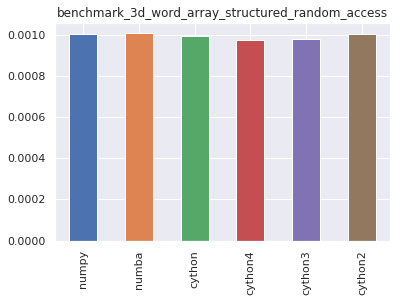

In [72]:
plot("benchmark_3d_word_array_structured_random_access")

All is essentially equal in the 3D lookup world. Note that these benchmarks use a cutoff for "added realism," while the old feasibility did not.

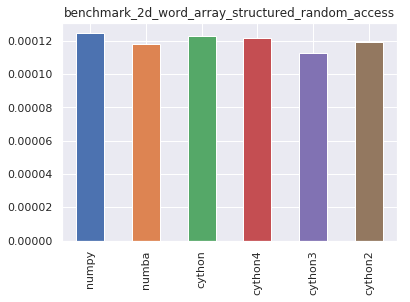

In [73]:
plot("benchmark_2d_word_array_structured_random_access")

Looks like either full-Cython implementations win, but we're definitely splitting hairs. Again, cutoff guaranteed.

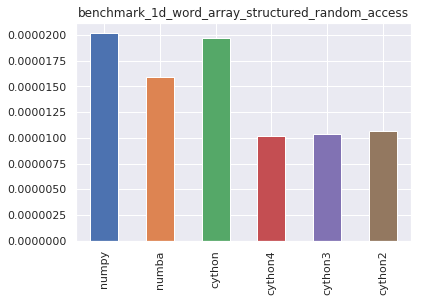

In [74]:
plot("benchmark_1d_word_array_structured_random_access")

Now here's an interesting one. There's actually no guaranteed cutoff in this case. Looks like cython's have better worst-case characteristics (could be wrong - the np.concat is maybe horribly heavy).

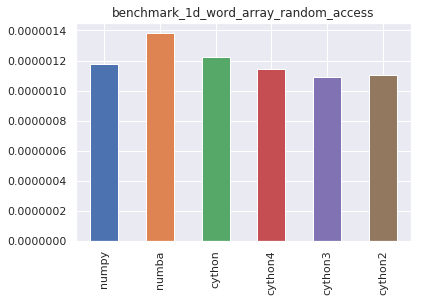

In [75]:
plot("benchmark_1d_word_array_random_access")

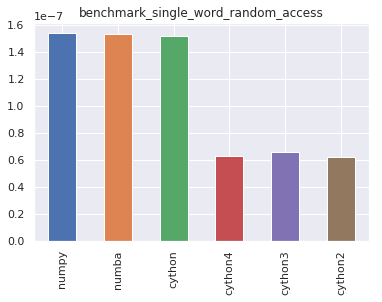

In [76]:
plot("benchmark_single_word_random_access")

Now this is the most interesting... I don't have an explanation for this.

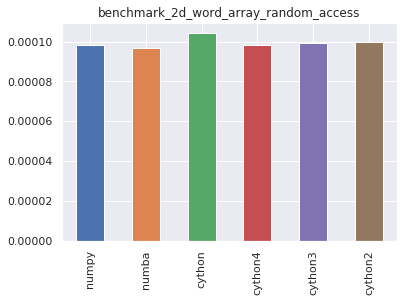

In [77]:
plot("benchmark_2d_word_array_random_access")